## EMMA step 2: Projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing

###  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue. As in EMMALAB, the EM data are projected into the streamwater PCA space.

### - Event-based PCAs: take as function parameters: site, date range, EM1, EM2, EM3

### 

## To DO

- [ ] Event A 12/19 ROS (Just Wade and Potash)
- [ ] Event B 2/24
- [ ] Event C 3/4
- [ ] Event D 3/11 (Wade only)
- [ ] Event E 3/26 Freshet

In [1]:
# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_event_pca_with_avgEM(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, following the EMMALAB workflow:
    PCA is fit ONLY on streamwater (mixture) data, then endmembers are projected
    into that PCA space.
    Also plots AvgEMScore: mean PC score for each endmember type.
    """

    # Site-specific tracers
    if site == "Wade":
        tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    elif site == "Potash":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'K_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'Wade', 'Potash', or 'Hungerford'.")

    # Ensure datetime column is datetime type
    data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y", errors="coerce")

    # Subset streamwater (mixture) in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow", "Isco"])) &
        (data["Date"] >= pd.to_datetime(start_date)) &
        (data["Date"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA for stream tracers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Date"] = stream["Date"]

    # Fill NA for endmembers with mean (per tracer)
    subset_endmembers = endmembers[tracers].copy()
    subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Date"] = endmembers["Date"].values

    # -----------------------
    # EMMALAB PCA logic
    # -----------------------
    scaler = StandardScaler()
    scaled_stream = scaler.fit_transform(subset_stream[tracers])

    pca = PCA(n_components=2)
    stream_pca_result = pca.fit_transform(scaled_stream)
    subset_stream["PC1"] = stream_pca_result[:, 0]
    subset_stream["PC2"] = stream_pca_result[:, 1]

    scaled_endmembers = scaler.transform(subset_endmembers[tracers])
    endmember_pca_result = pca.transform(scaled_endmembers)
    subset_endmembers["PC1"] = endmember_pca_result[:, 0]
    subset_endmembers["PC2"] = endmember_pca_result[:, 1]

    # Combine
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # -----------------------
    # Compute AvgEMScore + SD
    # -----------------------
    stats_em = (
        subset_endmembers.groupby("Type")[["PC1", "PC2"]]
        .agg(['mean', 'std'])
    )
    stats_em.columns = ['PC1_mean', 'PC1_std', 'PC2_mean', 'PC2_std']
    stats_em = stats_em.reset_index()
    stats_em["Group"] = "AvgEMScore"

    # -----------------------
    # Plotting
    # -----------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # --- set font sizes globally (scale ~1.5× default) ---
    mpl.rcParams.update({
        "font.size": 18,          # base font size
        "axes.titlesize": 18,     # title
        "axes.labelsize": 18,     # x and y labels
        "xtick.labelsize": 14,    # tick labels
        "ytick.labelsize": 14,
        "legend.fontsize": 18
    })

    # Streamwater points
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Endmember markers/colors
    endmember_markers = {
        'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        'Groundwater': 'D', 'Baseflow': 'P'
    }
    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba',
              '#2ca25f', '#636363', '#8856a7', '#d95f0e']

    # Plot mean + error bars (instead of individual endmembers)
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em_stat = stats_em[stats_em["Type"] == etype]
        if not em_stat.empty:
            ax.errorbar(
                em_stat["PC1_mean"], em_stat["PC2_mean"],
                xerr=em_stat["PC1_std"], yerr=em_stat["PC2_std"],
                fmt=endmember_markers[etype],  # marker style
                color=color, ecolor=color,
                elinewidth=1.5, capsize=4,
                markersize=12, markeredgecolor='black',
                label=f"{etype} mean ±1 SD"
            )

    # Draw mixing space polygon
    if len(stats_em) >= 3:
        from scipy.spatial import ConvexHull
        import numpy as np

        points = stats_em[["PC1_mean", "PC2_mean"]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_points = np.vstack([hull_points, hull_points[0]])

        ax.plot(hull_points[:,0], hull_points[:,1],
                linestyle='-', color='black', linewidth=1.5,
                label="Mixing space")
        ax.fill(hull_points[:,0], hull_points[:,1],
                facecolor='grey', alpha=0.1)

    # Variance explained
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

    ax.set_title(title)

    # --- Save plot as 'output/site_title.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    save_event_name = title.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{site}_{save_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")
    
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

Saved plot to: output/Wade_Wade_Dec._ROS_Dec_29–Jan_02,_2025.jpg


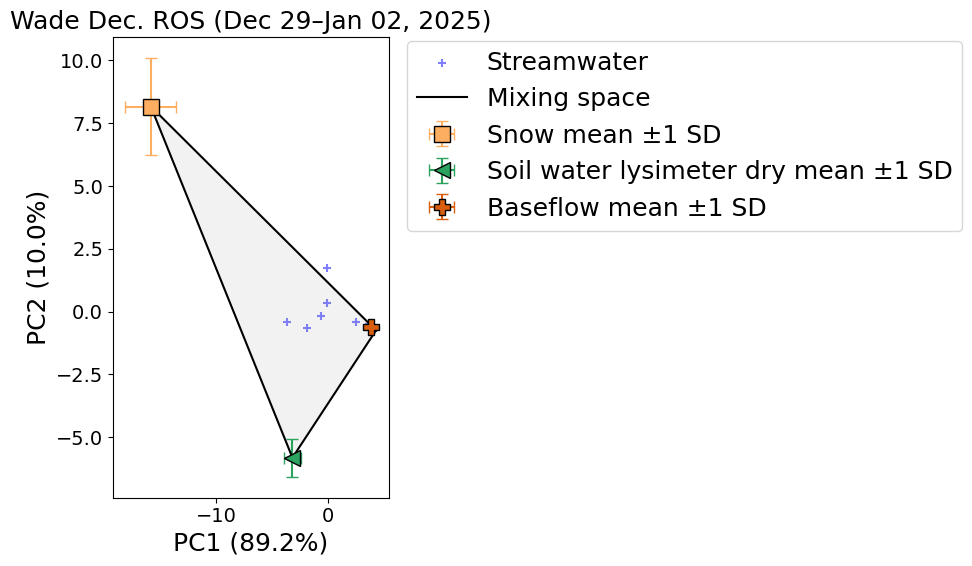

In [6]:
# Load the full RI25 dataset
df = pd.read_csv("data/newrnet-chemistry/RI25/RI25-IC-ICP-isotope-joined.csv")

####################
# Wade RI25 events #
####################

# Event A
# Wade 12/29 ROS event
# Potential endmembers: 
    # "RI25-1126", "RI25-1031", "RI25-1090", "RI25-1183", "RI25-1201", "RI25-1290" 12/06/2024 (good baseflow); potential baseflow 12/10/2024 + 12/28/2024; 03/04/2025; 03/11/2025; 03/03/2025
    # "RI25-1123", "RI25-1115", "RI25-1305" Soil lysimeter dry 12/17/2024; 2/10/2025; 04/04/2024
    # "RI25-1306" Soil water lysimeter wet
    # "RI25-1227", "RI25-1229", "RI25-1301", "RI25-1304" Snowmelt lysimeter 03/07/2025; 03/17/2025; 03/28/2025; 04/04/2025
    # "RI25-1128", "RI25-1130" Snow core 12/10/2024; Snow core post rain 12/12/2024

plot_event_pca_with_avgEM(
    data=df,
    site="Wade",
    start_date="2024-12-26",
    end_date="2025-01-03",
    endmember_ids=["RI25-1128", "RI25-1130", # Snow cores from Dec '24
                   #"RI25-1227", "RI25-1229", "RI25-1301", "RI25-1304", # Snowmelt lysimeter
                   #"RI25-1306", # Soil water lysimeter wet
                   "RI25-1123", "RI25-1115", #"RI25-1305", # Soil water lysimeter dry 
                   "RI25-1126", "RI25-1031", "RI25-1090",],  #Baseflow
    title="Wade Dec. ROS (Dec 29–Jan 02, 2025)"
)